# Use Facebook Prophet to decompose prices

Since BTC is going down these days, I think it's good to analyze a bit what's going on on the 1hr timeframe.

In [1]:
import pandas as pd
import numpy as np

## Load data

In [2]:
path1 = "/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/encrypted/bybit_sub_secret.key"
path2 = "/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/encrypted/bybit_sub_encrypted_keys.txt"

In [3]:
from pybit.unified_trading import HTTP
from encrypted.encryption import load_keys

api_key, api_secret = load_keys(path1, path2)
session = HTTP(
    testnet=False,
    api_key= api_key,
    api_secret = api_secret,
)

print(session.get_server_time())

{'retCode': 0, 'retMsg': 'OK', 'result': {'timeSecond': '1720265337', 'timeNano': '1720265337157146577'}, 'retExtInfo': {}, 'time': 1720265337157}


In [4]:
from utils.convert_datetime import convert_to_timestamp
from utils.get_data_bybit import get_data_with_volume_bybit

start_date = convert_to_timestamp("2024-05-01")
end_date = convert_to_timestamp("2024-07-06")

Data = get_data_with_volume_bybit(session, "BTCUSD", start_date, end_date, interval = "60", category = "linear", limit = 1000, invert = True)
Data.head()

                     openPrice  highPrice  lowPrice  closePrice    volume  \
startTime                                                                   
2024-05-25 00:00:00    68581.0    68708.0   68531.5     68564.0   4637348   
2024-05-25 01:00:00    68564.0    68735.5   68563.5     68639.5   5167647   
2024-05-25 02:00:00    68639.5    68843.0   68631.0     68831.5  12786058   
2024-05-25 03:00:00    68831.5    68920.0   68677.0     68791.5  17531678   
2024-05-25 04:00:00    68791.5    68882.5   68721.0     68819.0  12764973   

                         turnover  symbol  
startTime                                  
2024-05-25 00:00:00   67.57830595  BTCUSD  
2024-05-25 01:00:00   75.24092656  BTCUSD  
2024-05-25 02:00:00  185.91054693  BTCUSD  
2024-05-25 03:00:00  254.94928617  BTCUSD  
2024-05-25 04:00:00  185.56808372  BTCUSD  


,openPrice,highPrice,lowPrice,closePrice,volume,turnover,symbol
startTime,,,,,,,
2024-05-25 00:00:00,68581.0,68708.0,68531.5,68564.0,4637348,67.57830595,BTCUSD
2024-05-25 01:00:00,68564.0,68735.5,68563.5,68639.5,5167647,75.24092656,BTCUSD
2024-05-25 02:00:00,68639.5,68843.0,68631.0,68831.5,12786058,185.91054693,BTCUSD
2024-05-25 03:00:00,68831.5,68920.0,68677.0,68791.5,17531678,254.94928617,BTCUSD
2024-05-25 04:00:00,68791.5,68882.5,68721.0,68819.0,12764973,185.56808372,BTCUSD


In [5]:
Data.to_csv('/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/data/Bybit_BTC_1hr_25May_7July2024.csv', index=True)

## Ready to process

In [6]:
df = pd.read_csv('/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/data/Bybit_BTC_1hr_25May_7July2024.csv',
                 index_col=0, usecols=["closePrice", "startTime"])
df.head()

,closePrice
startTime,
2024-05-25 00:00:00,68564.0
2024-05-25 01:00:00,68639.5
2024-05-25 02:00:00,68831.5
2024-05-25 03:00:00,68791.5
2024-05-25 04:00:00,68819.0


In [7]:
#rename columns because facebook prophet is dumb
# Renaming the index and column
df.index.name = 'ds'
df.rename(columns={'closePrice': 'y'}, inplace=True)
# Resetting the index to make it a column
df.reset_index(inplace=True)
df

,ds,y
0,2024-05-25 00:00:00,68564.0
1,2024-05-25 01:00:00,68639.5
2,2024-05-25 02:00:00,68831.5
3,2024-05-25 03:00:00,68791.5
4,2024-05-25 04:00:00,68819.0
...,...,...
995,2024-07-05 11:00:00,55466.0
996,2024-07-05 12:00:00,55022.0
997,2024-07-05 13:00:00,55811.5
998,2024-07-05 14:00:00,55708.5


split the data into train and test preserving the chronological order

In [8]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size= 0.3, shuffle=False)

In [9]:
len(df_train)

700

In [10]:
len(df_test)

300

In [17]:
df_train

,ds,y
0,2024-05-25 00:00:00,68564.0
1,2024-05-25 01:00:00,68639.5
2,2024-05-25 02:00:00,68831.5
3,2024-05-25 03:00:00,68791.5
4,2024-05-25 04:00:00,68819.0
...,...,...
695,2024-06-22 23:00:00,64255.5
696,2024-06-23 00:00:00,64454.0
697,2024-06-23 01:00:00,64450.0
698,2024-06-23 02:00:00,64484.0


In [11]:
from prophet import Prophet

In [12]:
m = Prophet(changepoint_prior_scale=0.01).fit(df_train)

20:28:59 - cmdstanpy - INFO - Chain [1] start processing
20:28:59 - cmdstanpy - INFO - Chain [1] done processing


/Users/leonardoplacidi/opt/anaconda3/envs/BT/lib/python3.9/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
/Users/leonardoplacidi/opt/anaconda3/envs/BT/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/leonardoplacidi/opt/anaconda3/envs/BT/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',

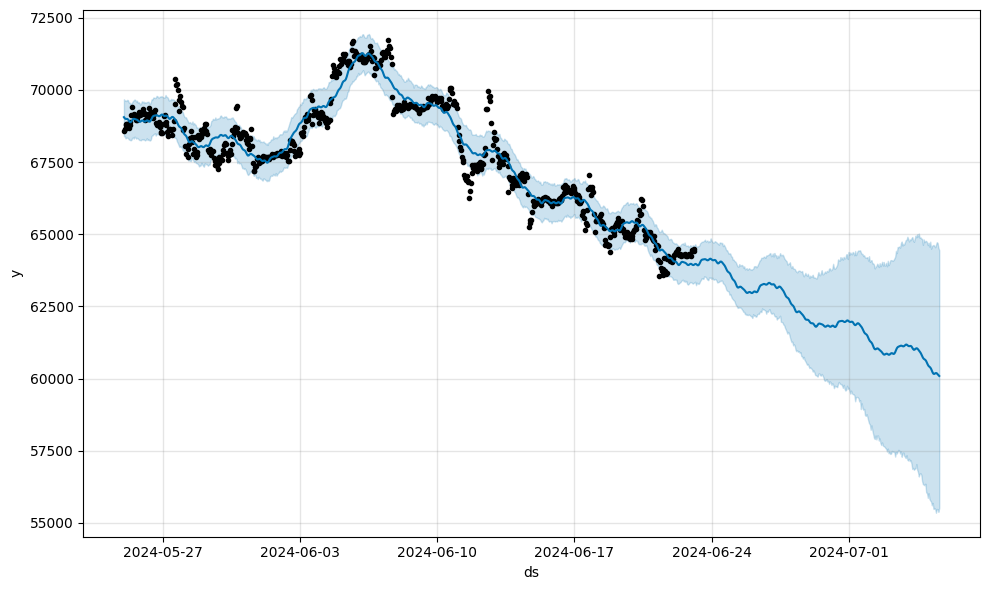

In [13]:
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

/Users/leonardoplacidi/opt/anaconda3/envs/BT/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/leonardoplacidi/opt/anaconda3/envs/BT/lib/python3.9/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/Users/leonardoplacidi/opt/anaconda3/envs/BT/lib/python3.9/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Serie

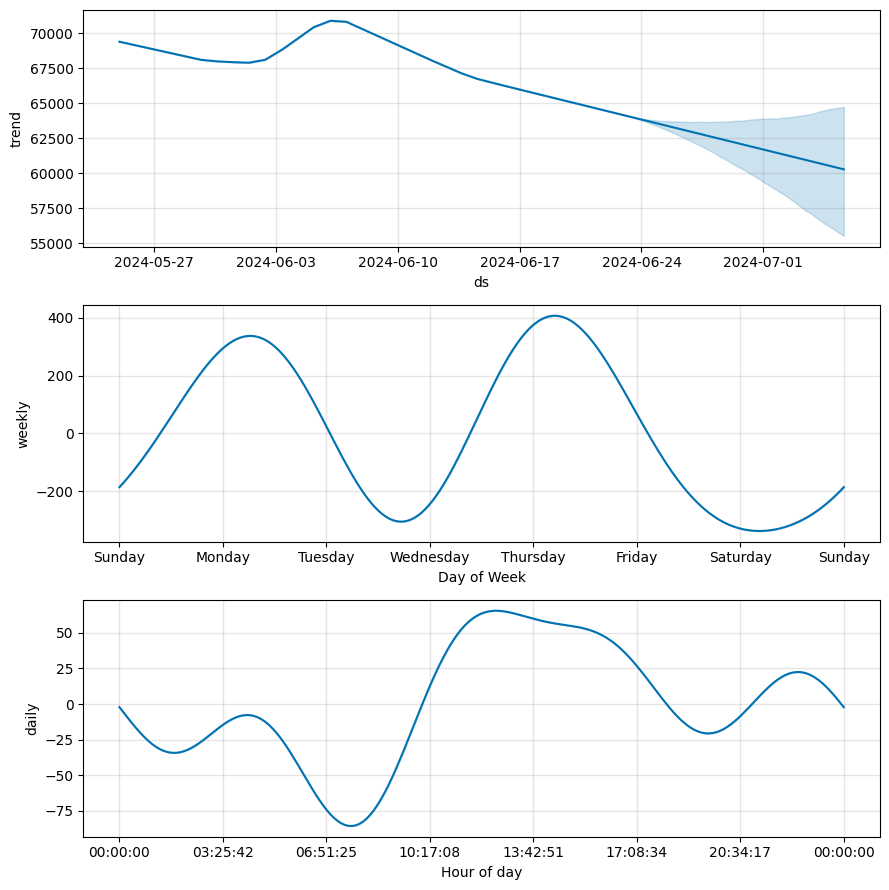

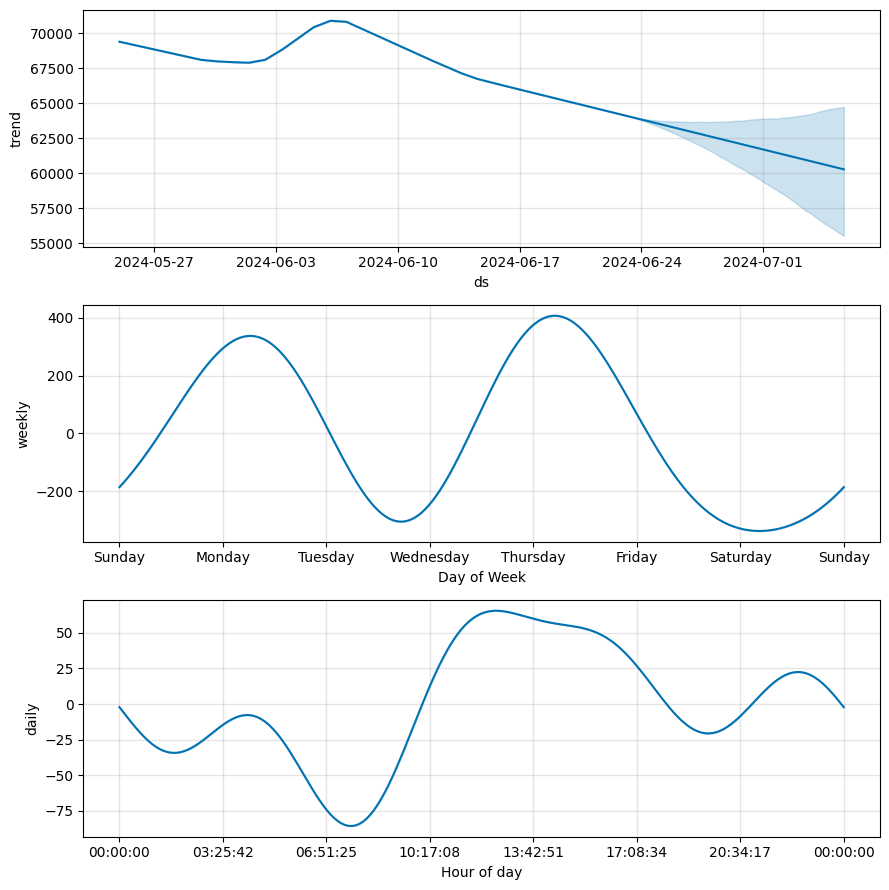

In [14]:
m.plot_components(fcst)

Facebook Prophet said to short BITCOIN and look it was right. A good stop loss above 62.500 would have brought much profit.

<Axes: >

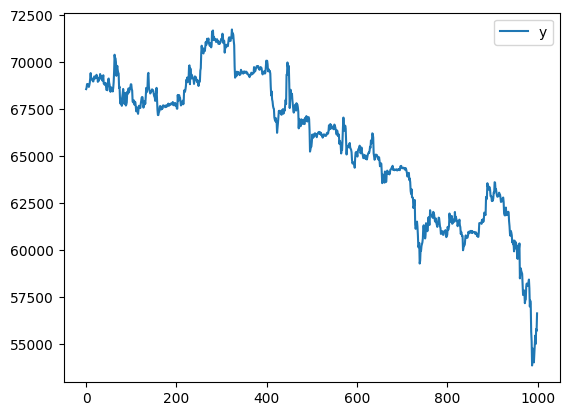

In [15]:
df.plot()

## What's gonna happen next? 

20:29:43 - cmdstanpy - INFO - Chain [1] start processing
20:29:43 - cmdstanpy - INFO - Chain [1] done processing
/Users/leonardoplacidi/opt/anaconda3/envs/BT/lib/python3.9/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(
/Users/leonardoplacidi/opt/anaconda3/envs/BT/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/leonardoplacidi/opt/anaconda3/envs/BT/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain th

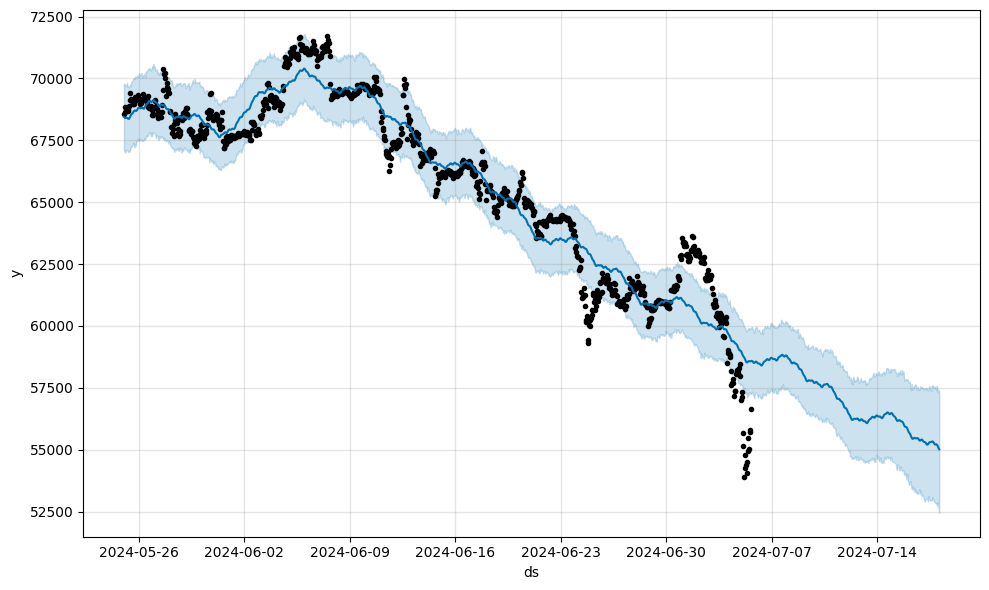

In [16]:
m = Prophet(changepoint_prior_scale=0.01).fit(df)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)